* To check my four days mean current without Coriolis force.

In [1]:
%matplotlib inline
from IPython.core.display import Image,display
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools,stormtools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import glob
import codar

In [2]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]

In [4]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st = 3

# no f for one month

In [7]:
uv = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OctMeanCurrent/codar_all_large.nc'); 
uv_noF = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/noF/codar_noF.nc')

In [8]:
def plot_all(d,cmin=0, cmax = 0.3,lonmax =-123., lonmin =-123.7, latmax =49.35, latmin = 48.9 ):  
    ncs = [uv,uv_noF]
    dep = uv.variables['depthu']
    types = ['f at {h:.2f} m'.format(h=dep[d]),'no f at {h:.2f} m'.format(h=dep[d])]
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    fig, axs = plt.subplots(1,3,figsize = (21,6))
    for nc,tp,ax in zip(ncs,types, axs[:2]):
        u_6= nc.variables['vozocrtx']
        v_6 = nc.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)

        u_m[tp] =u_mean6[d,:,:]
        v_m[tp] =v_mean6[d,:,:]
        ##unstagger u v
        U_m[tp],V_m[tp] = viz_tools.unstagger(u_m[tp],v_m[tp])
        #rotate
        theta = np.pi*29/180
        U_m[tp] = U_m[tp]*np.cos(theta) - V_m[tp]*np.sin(theta)
        V_m[tp] = U_m[tp]*np.sin(theta) +V_m[tp]*np.cos(theta)
        ##mask
        U_m[tp]=np.ma.masked_values(U_m[tp],0)
        V_m[tp]=np.ma.masked_values(V_m[tp],0)
        lon[tp] = X[grid6][380:479,240:319]
        lat[tp] = Y[grid6][380:479,240:319]

        mesh=ax.pcolormesh(lon[tp], lat[tp],np.sqrt(U_m[tp]**2+V_m[tp]**2), cmap='Reds', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Total Velocity[m/s]', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
        quiver = ax.quiver(lon[tp][::st,::st], lat[tp][::st,::st], U_m[tp][::st,::st], V_m[tp][::st,::st],\
                            pivot='mid',scale=2.5,width=0.005, color='black')
        ax.quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
        viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_title(tp,fontsize = 20)
    ##diff
    mesh=axs[2].pcolormesh(lon[types[1]], lat[types[1]],\
                           np.sqrt(U_m[types[1]]**2+V_m[types[1]]**2) -np.sqrt(U_m[types[0]]**2+V_m[types[0]]**2) , \
                           cmap='bwr', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = axs[2].quiver(lon[types[1]][::st,::st], lat[types[1]][::st,::st], \
                           U_m[types[1]][::st,::st]-U_m[types[0]][::st,::st],\
                       V_m[types[1]][::st,::st]-V_m[types[0]][::st,::st],pivot='mid',\
                           scale=2.5,width=0.005, color='black')
    axs[2].quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
    axs[2].set_title('nof - f')
    viz_tools.plot_land_mask(axs[2],grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(axs[2], grid6, coords = 'map', isobath = 4,color = 'DarkViolet')
    for ax in axs:
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(latmin, latmax)     
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    
    return fig

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


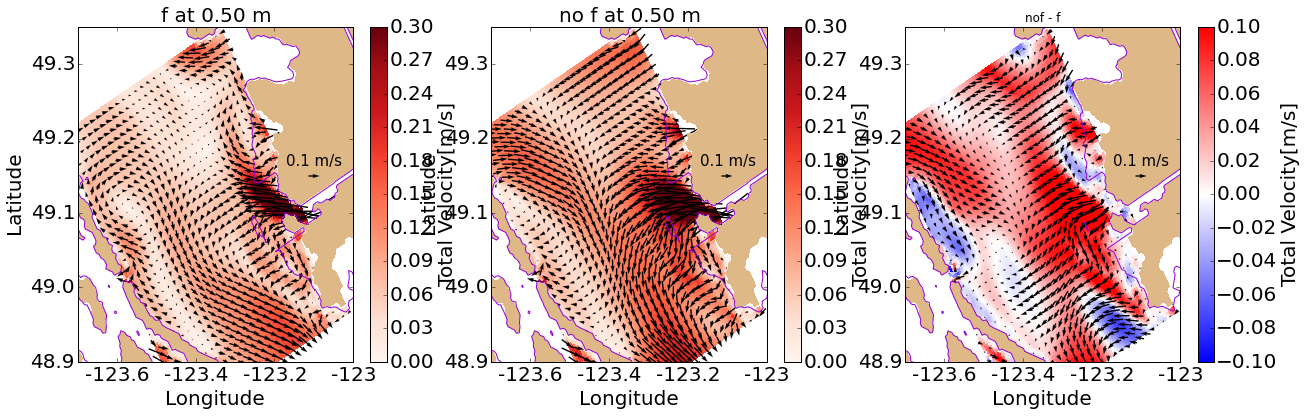

In [9]:
fig = plot_all(0)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


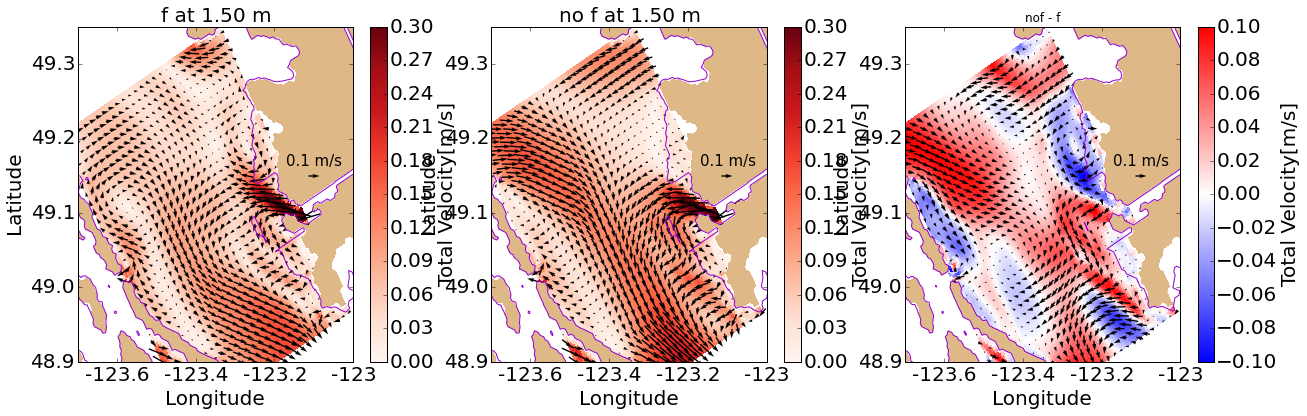

In [10]:
fig = plot_all(1)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


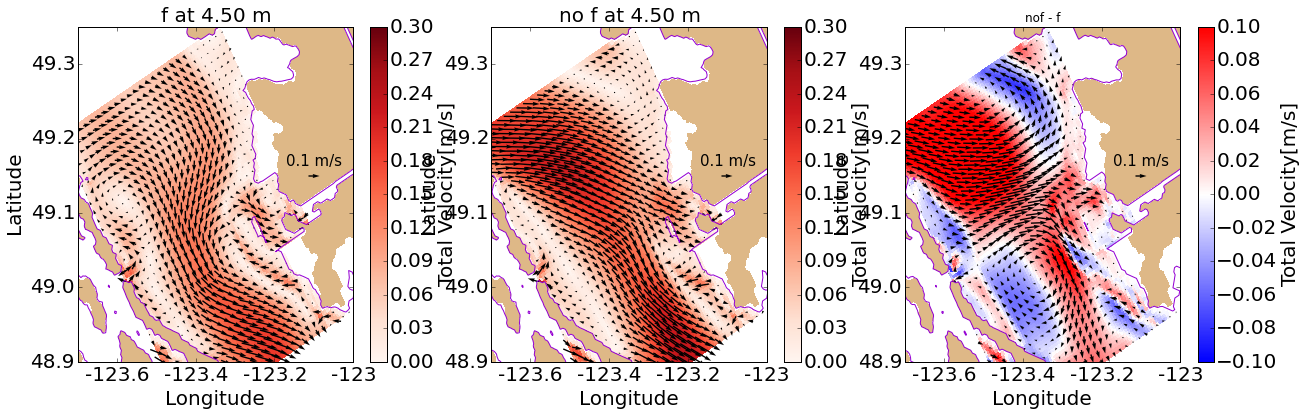

In [11]:
fig = plot_all(4)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


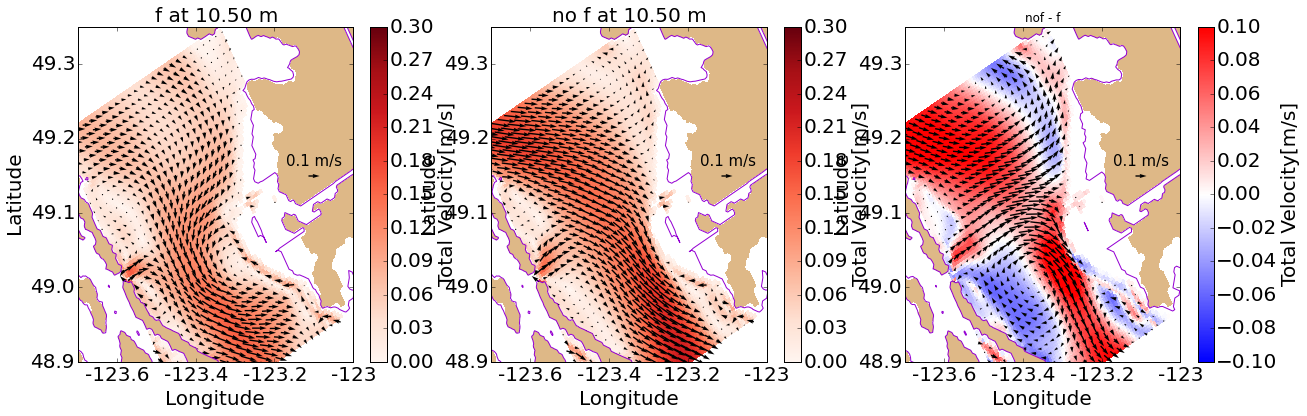

In [12]:
fig = plot_all(10)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


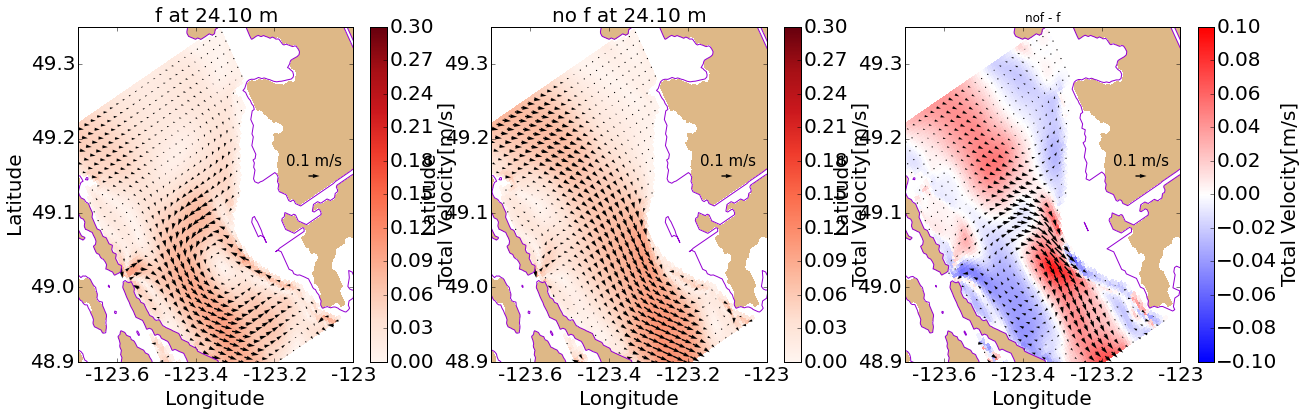

In [13]:
fig = plot_all(20)

* nth baroclinic Rossby radius: R = $\frac{Nh_{0}}{n \pi f}$, n = 1,2 etc, the length scale where rotational effect becomes as importance as gravity wave effect in the evolution of the flow disturbance.